Straighten an image based on a mask using a mesh of points

This is the mask and image we will use:

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


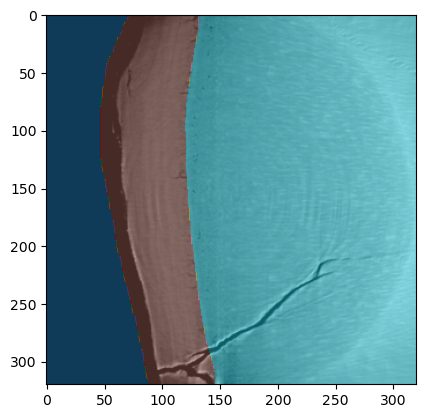

In [12]:
""" Display the image and mask """
import pickle
import matplotlib.pyplot as plt

with open("cementum_data.pickle", "rb") as data:
    _, _, test_images, test_masks = pickle.load(data)


# Just pick the first image for now
image, mask = test_images[0], test_masks[0]
plt.imshow(image, cmap="grey")
plt.imshow(mask, cmap="tab10", alpha=0.5)

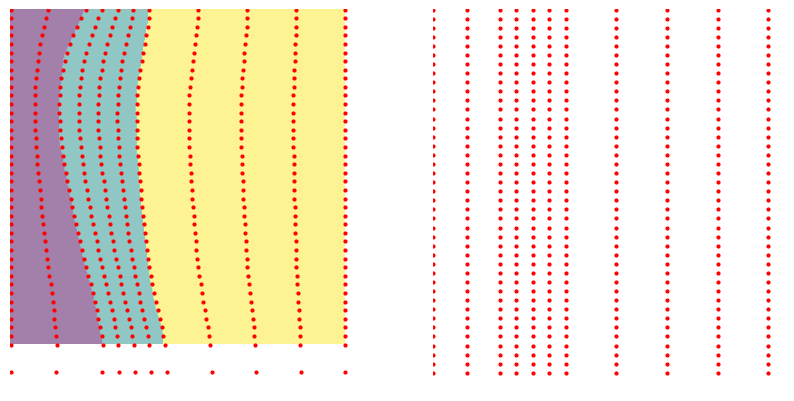

In [16]:
"""
Create grids of points to map to/from

"""
from cementum import straighten

n_x, n_y = 5, 40
n_left, n_right = 3, 5

plot_kw = {"marker": "o", "linestyle": "none"}

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
for axis in axes:
    axis.set_aspect("equal")
    axis.set_axis_off()

# Concatenate all the points together
curve_pts = straighten.mask_mesh(mask, n_y, (n_left, n_x, n_right))
straight_pts = straighten.straight_mesh(mask, n_y, (n_left, n_x, n_right))

axes[0].plot(curve_pts[:, 0], curve_pts[:, 1], color="r", **plot_kw, markersize=2)
axes[0].imshow(mask, alpha=0.5)
axes[1].plot(straight_pts[:, 0], straight_pts[:, 1], color="r", **plot_kw, markersize=2)

fig.savefig("mesh.png")

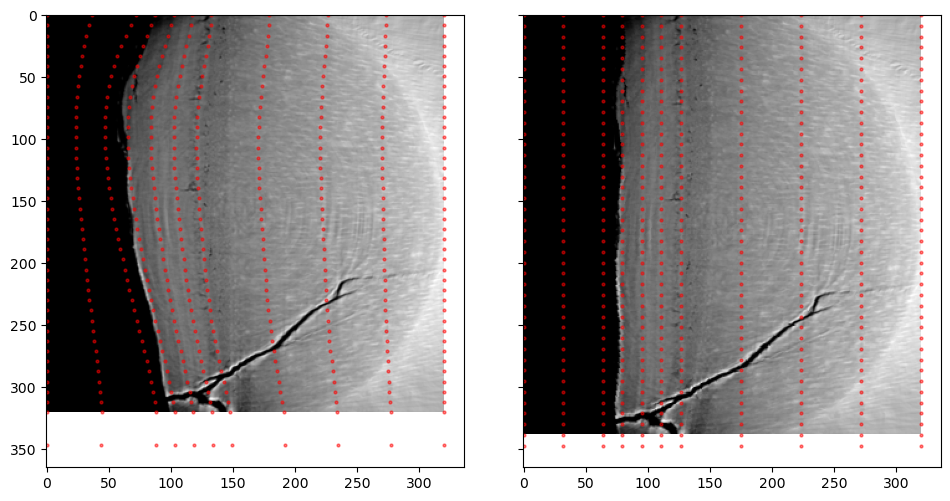

In [47]:
"""
Straighten the image

"""
import numpy as np

image_transformed = straighten.apply_transformation(image, curve_pts, straight_pts, order=0)

# Display the straightened image
plot_kw = {**plot_kw, "markersize": 2, "color": "r", "alpha": 0.5}
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

axes[0].imshow(image, cmap="grey")

axes[1].imshow(image_transformed, cmap="grey")

fig.tight_layout()

fig.savefig("straightened_comparison.png")
axes[0].plot(curve_pts[:, 0], curve_pts[:, 1], **plot_kw)
axes[1].plot(straight_pts[:, 0], straight_pts[:, 1], **plot_kw)

# Save the straightened image
np.save("straightened_image.npy", image_transformed)

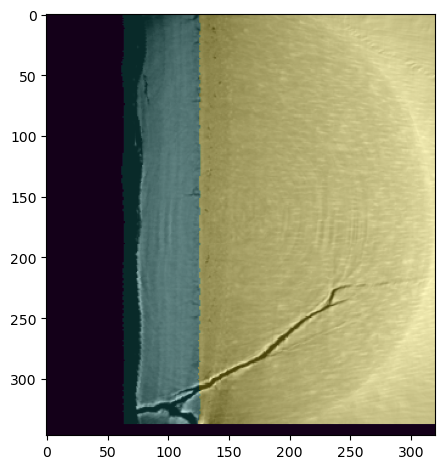

In [33]:
""" Also straighten the mask """
mask_transformed = straighten.apply_transformation(mask, curve_pts, straight_pts)

# Display the straightened mask
fig, axis = plt.subplots()
axis.imshow(mask_transformed, alpha=0.3, zorder=1)
fig.tight_layout()

fig.savefig("straightened_mask.png")
axis.imshow(image_transformed, cmap="grey", zorder=0)

np.save("straightened_mask.npy", mask_transformed)

Disadvantages:
 - Has cut off the bottom bit of the image (todo)
 - We've had to make a decision about the transformation
    - Here we've kept the area of the masked region constant (ideally?) but we could have kept the average width constant (?) 

Text(0.5, 0.98, 'Horizontal slices')

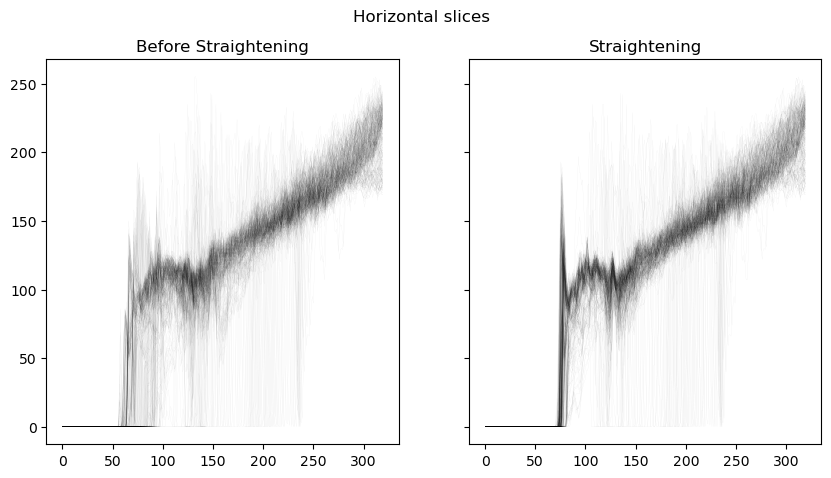

In [6]:
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

axes[0].set_title("Before Straightening")
axes[1].set_title("Straightening")

kw = {"alpha": 0.1, "color": "k", "linewidth": 0.1}
for y in image:
    axes[0].plot(y, **kw)
for y in image_transformed:
    axes[1].plot(y, **kw)


fig.suptitle("Horizontal slices")

Text(0.5, 1.0, 'After Straightening')

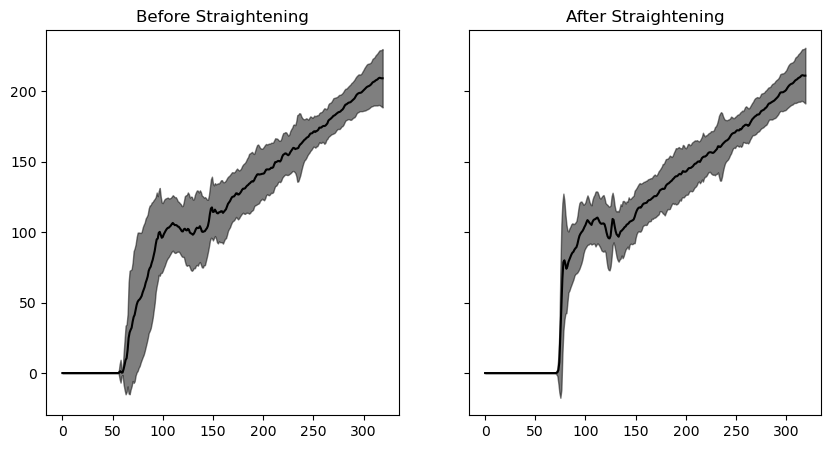

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

axes[0].plot(np.mean(image, axis=0), color="k")
axes[1].plot(np.mean(image_transformed, axis=0), color="k")

axes[0].fill_between(
    np.arange(image.shape[1]),
    np.mean(image, axis=0) - np.std(image, axis=0),
    np.mean(image, axis=0) + np.std(image, axis=0),
    color="k",
    alpha=0.5
)

axes[1].fill_between(
    np.arange(image.shape[1]),
    np.mean(image_transformed, axis=0) - np.std(image_transformed, axis=0),
    np.mean(image_transformed, axis=0) + np.std(image_transformed, axis=0),
    color="k",
    alpha=0.5,
)

axes[0].set_title("Before Straightening")
axes[1].set_title("After Straightening")

We can see the peaks/troughs much more clearly in the straightened image (but it still isn't perfect)

This might give us a good baseline to work with in terms of layer segmentation

There's also a much sharper turn-on with the straightened image (good)

Interestingly the width of the band in the dentine seems to be basically the same in both cases; maybe we can use this for something

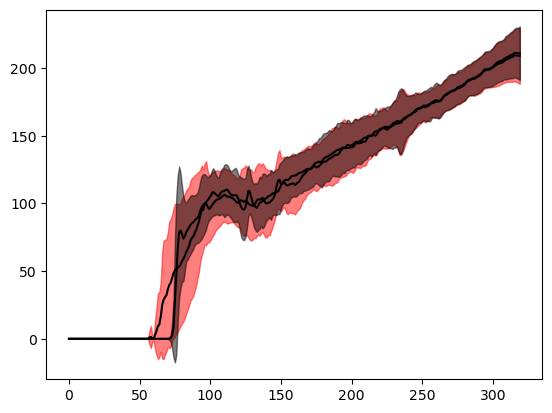

In [8]:
fig, axis = plt.subplots()

axis.plot(np.mean(image, axis=0), color="k")
axis.plot(np.mean(image_transformed, axis=0), color="k")

axis.fill_between(
    np.arange(image.shape[1]),
    np.mean(image, axis=0) - np.std(image, axis=0),
    np.mean(image, axis=0) + np.std(image, axis=0),
    color="r",
    alpha=0.5,
)

axis.fill_between(
    np.arange(image.shape[1]),
    np.mean(image_transformed, axis=0) - np.std(image_transformed, axis=0),
    np.mean(image_transformed, axis=0) + np.std(image_transformed, axis=0),
    color="k",
    alpha=0.5,
)

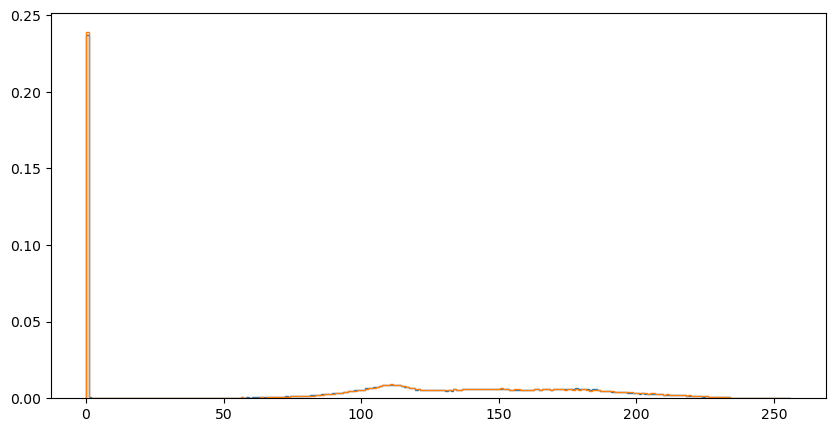

In [9]:
fig, axis = plt.subplots(1, 1, figsize=(10, 5))
kw = {"bins": np.linspace(0, 256, 256), "histtype": "step", "density": True}
axis.hist(image.ravel(), **kw)
axis.hist(image_transformed.ravel(), **kw)
None